In [1]:
import cv2
import numpy as np
import os
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
emnist_mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

In [2]:
class CAPTCHAClassifier(nn.Module):
    def __init__(self, num_classes=62):
        super(CAPTCHAClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2, 2)

        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
def load_model(model_path='model.pth'):
    model = CAPTCHAClassifier()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def preprocess_character_image(image):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0)
    return image

In [4]:
def load_captcha_image(image_path):
    image = cv2.imread(image_path)
    return image


def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth_image = cv2.medianBlur(gray, 5)
    thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((4, 4), np.uint8)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    return thresh


def merge_contours(contours, min_distance=12):
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    merged_boxes = []

    for box in bounding_boxes:
        x, y, w, h = box
        merged = False
        for i, (mx, my, mw, mh) in enumerate(merged_boxes):
            if abs(x - mx) < min_distance or abs((x + w) - (mx + mw)) < min_distance:
                merged_boxes[i] = (
                    min(x, mx), min(y, my), max(x + w, mx + mw) - min(x, mx), max(y + h, my + mh) - min(y, my))
                merged = True
                break
        if not merged:
            merged_boxes.append((x, y, w, h))
    merged_contours = [np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.int32) for (x, y, w, h) in
                       merged_boxes]

    return merged_contours


def split_wide_contours(contour, image, width_threshold=40):
    x, y, w, h = cv2.boundingRect(contour)
    if w > width_threshold:
        num_splits = int(np.ceil(w / width_threshold))
        segment_width = w // num_splits

        sub_contours = []
        for i in range(num_splits):
            sub_x = x + i * segment_width
            sub_w = segment_width if i < num_splits - 1 else w - (num_splits - 1) * segment_width
            sub_contour = np.array([[sub_x, y], [sub_x + sub_w, y], [sub_x + sub_w, y + h], [sub_x, y + h]],
                                   dtype=np.int32)
            sub_contours.append(sub_contour)
        return sub_contours
    else:
        return [contour]


def find_character_contours(thresh_image, width_threshold=40, expand_by=10):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    character_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 5 < w and 5 < h:
            y = max(0, y - expand_by)
            h = h + 2 * expand_by

            split_contours = split_wide_contours(contour, thresh_image, width_threshold)
            for sc in split_contours:
                x_sc, y_sc, w_sc, h_sc = cv2.boundingRect(sc)
                expanded_contour = np.array([[x_sc, y], [x_sc + w_sc, y], [x_sc + w_sc, y + h], [x_sc, y + h]],
                                            dtype=np.int32)
                character_contours.append(expanded_contour)

    character_contours = sorted(character_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    merged_contours = merge_contours(character_contours)

    return merged_contours


In [5]:

def predict_character(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    return emnist_mapping[predicted.item()]


def decrypt_captcha(image, contours, model):
    captcha_text = ""
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]
        gray = cv2.cvtColor(char_image, cv2.COLOR_BGR2GRAY)
        smooth_image = cv2.medianBlur(gray, 5)
        thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        char_image = preprocess_character_image(thresh)
        predicted_char = predict_character(model, char_image)
        captcha_text += predicted_char
    return captcha_text


In [6]:
def visualize_segmentation(image, contours, preprocessed_image):
    scaled_image = cv2.resize(image, (400, 100))
    image_with_boxes = scaled_image.copy()

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        scale_x = scaled_image.shape[1] / image.shape[1]
        scale_y = scaled_image.shape[0] / image.shape[0]
        cv2.rectangle(image_with_boxes,
                      (int(x * scale_x), int(y * scale_y)),
                      (int((x + w) * scale_x), int((y + h) * scale_y)),
                      (0, 255, 0), 2)

    rgb_image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image_with_boxes)
    plt.axis('off')
    plt.title('Original Image with Contours')


def visualize_extracted_characters(image, contours, target_size=(28, 28)):
    plt.figure(figsize=(4, 1))
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]

        char_image_resized = cv2.resize(char_image, target_size)
        gray = cv2.cvtColor(char_image_resized, cv2.COLOR_BGR2GRAY)
        smooth_image = cv2.medianBlur(gray, 5)
        thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        plt.subplot(1, len(contours), i + 1)
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

C:\Users\mitya\AppData\Local\Temp\ipykernel_8924\307774687.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torc

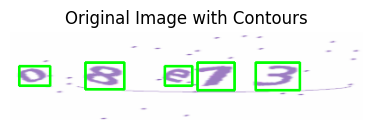

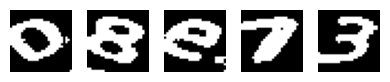

Predicted CAPTCHA: 0N06W | Actual CAPTCHA: 08e13


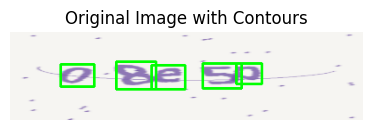

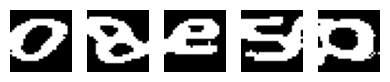

Predicted CAPTCHA: 0QQN0 | Actual CAPTCHA: 08e5p


In [8]:
def process_captcha(image_path, model):
    image = load_captcha_image(image_path)
    thresh_image = preprocess_image(image)
    contours = find_character_contours(thresh_image)

    visualize_segmentation(image, contours, thresh_image)
    visualize_extracted_characters(image, contours)

    decrypted_captcha = decrypt_captcha(image, contours, model)
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    print(f"Predicted CAPTCHA: {decrypted_captcha} | Actual CAPTCHA: {image_name}")


model = load_model('model.pth')

input_dir = '../../data/captchas_dataset_1/Large_Captcha_Dataset'
image_files = os.listdir(input_dir)[1818:1820]

for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    process_captcha(image_path, model)
